# Understanding the Data Distribution

In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras


import matplotlib.pyplot as plt
import cv2


from tqdm.notebook import tqdm

In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Loading Kaggle data

In [ ]:
auth_json = '{"username":"washingtongold","key":"4ca0d799ecdae274f4a27c1a2a41b083"}'

if not os.path.exists('/root/.kaggle'):
  os.makedirs('/root/.kaggle')
with open('/root/.kaggle/kaggle.json', 'w') as f:
    f.write(auth_json)
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d jessicali9530/stanford-dogs-dataset

100% 750M/750M [00:08<00:00, 101MB/s]
100% 750M/750M [00:08<00:00, 95.3MB/s]


In [ ]:
!mkdir stanford-dogs
!mv stanford-dogs-dataset.zip stanford-dogs/
!cd stanford-dogs; unzip stanford-dogs-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/Images/n02108089-boxer/n02108089_11687.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_117.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11807.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_11875.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_122.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12232.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_125.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12738.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12739.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_12827.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13340.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_13526.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1353.jpg  
  inflating: images/Images/n02108089-boxer/n02108089_1355.jpg  
  inflating: images/Images/n02108089-boxer/n021

Load EfficientNet model.

In [ ]:
model = keras.applications.EfficientNetB0(
    input_shape = (224, 224, 3),
    include_top = True,
    weights = "imagenet"
)
model = keras.models.Model(inputs = model.inputs,
                           outputs = model.layers[-2].output)

21834768/21834768 [==============================] - 0s 0us/step


In [ ]:
embeddings = {}

img_folder = 'stanford-dogs/images/Images'
for class_folder in tqdm(os.listdir(img_folder)[:3]):
  curr_path = os.path.join(img_folder, class_folder)
  for img in tqdm(os.listdir(curr_path)):
    img_path = os.path.join(curr_path, img)
    img = plt.imread(img_path)

    resized = cv2.resize(img, (224, 224))
    embedding = np.squeeze(model.predict(np.expand_dims(resized, 0), verbose = 0))

    embeddings[img_path] = embedding

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/172 [00:00<?, ?it/s]

  0%|          | 0/151 [00:00<?, ?it/s]

  0%|          | 0/148 [00:00<?, ?it/s]

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA(n_components=2)
X = np.array(list(embeddings.values()))

In [ ]:
transformed = pca.fit_transform(X)

In [ ]:
pca.explained_variance_ratio_

array([0.22159383, 0.05544505], dtype=float32)

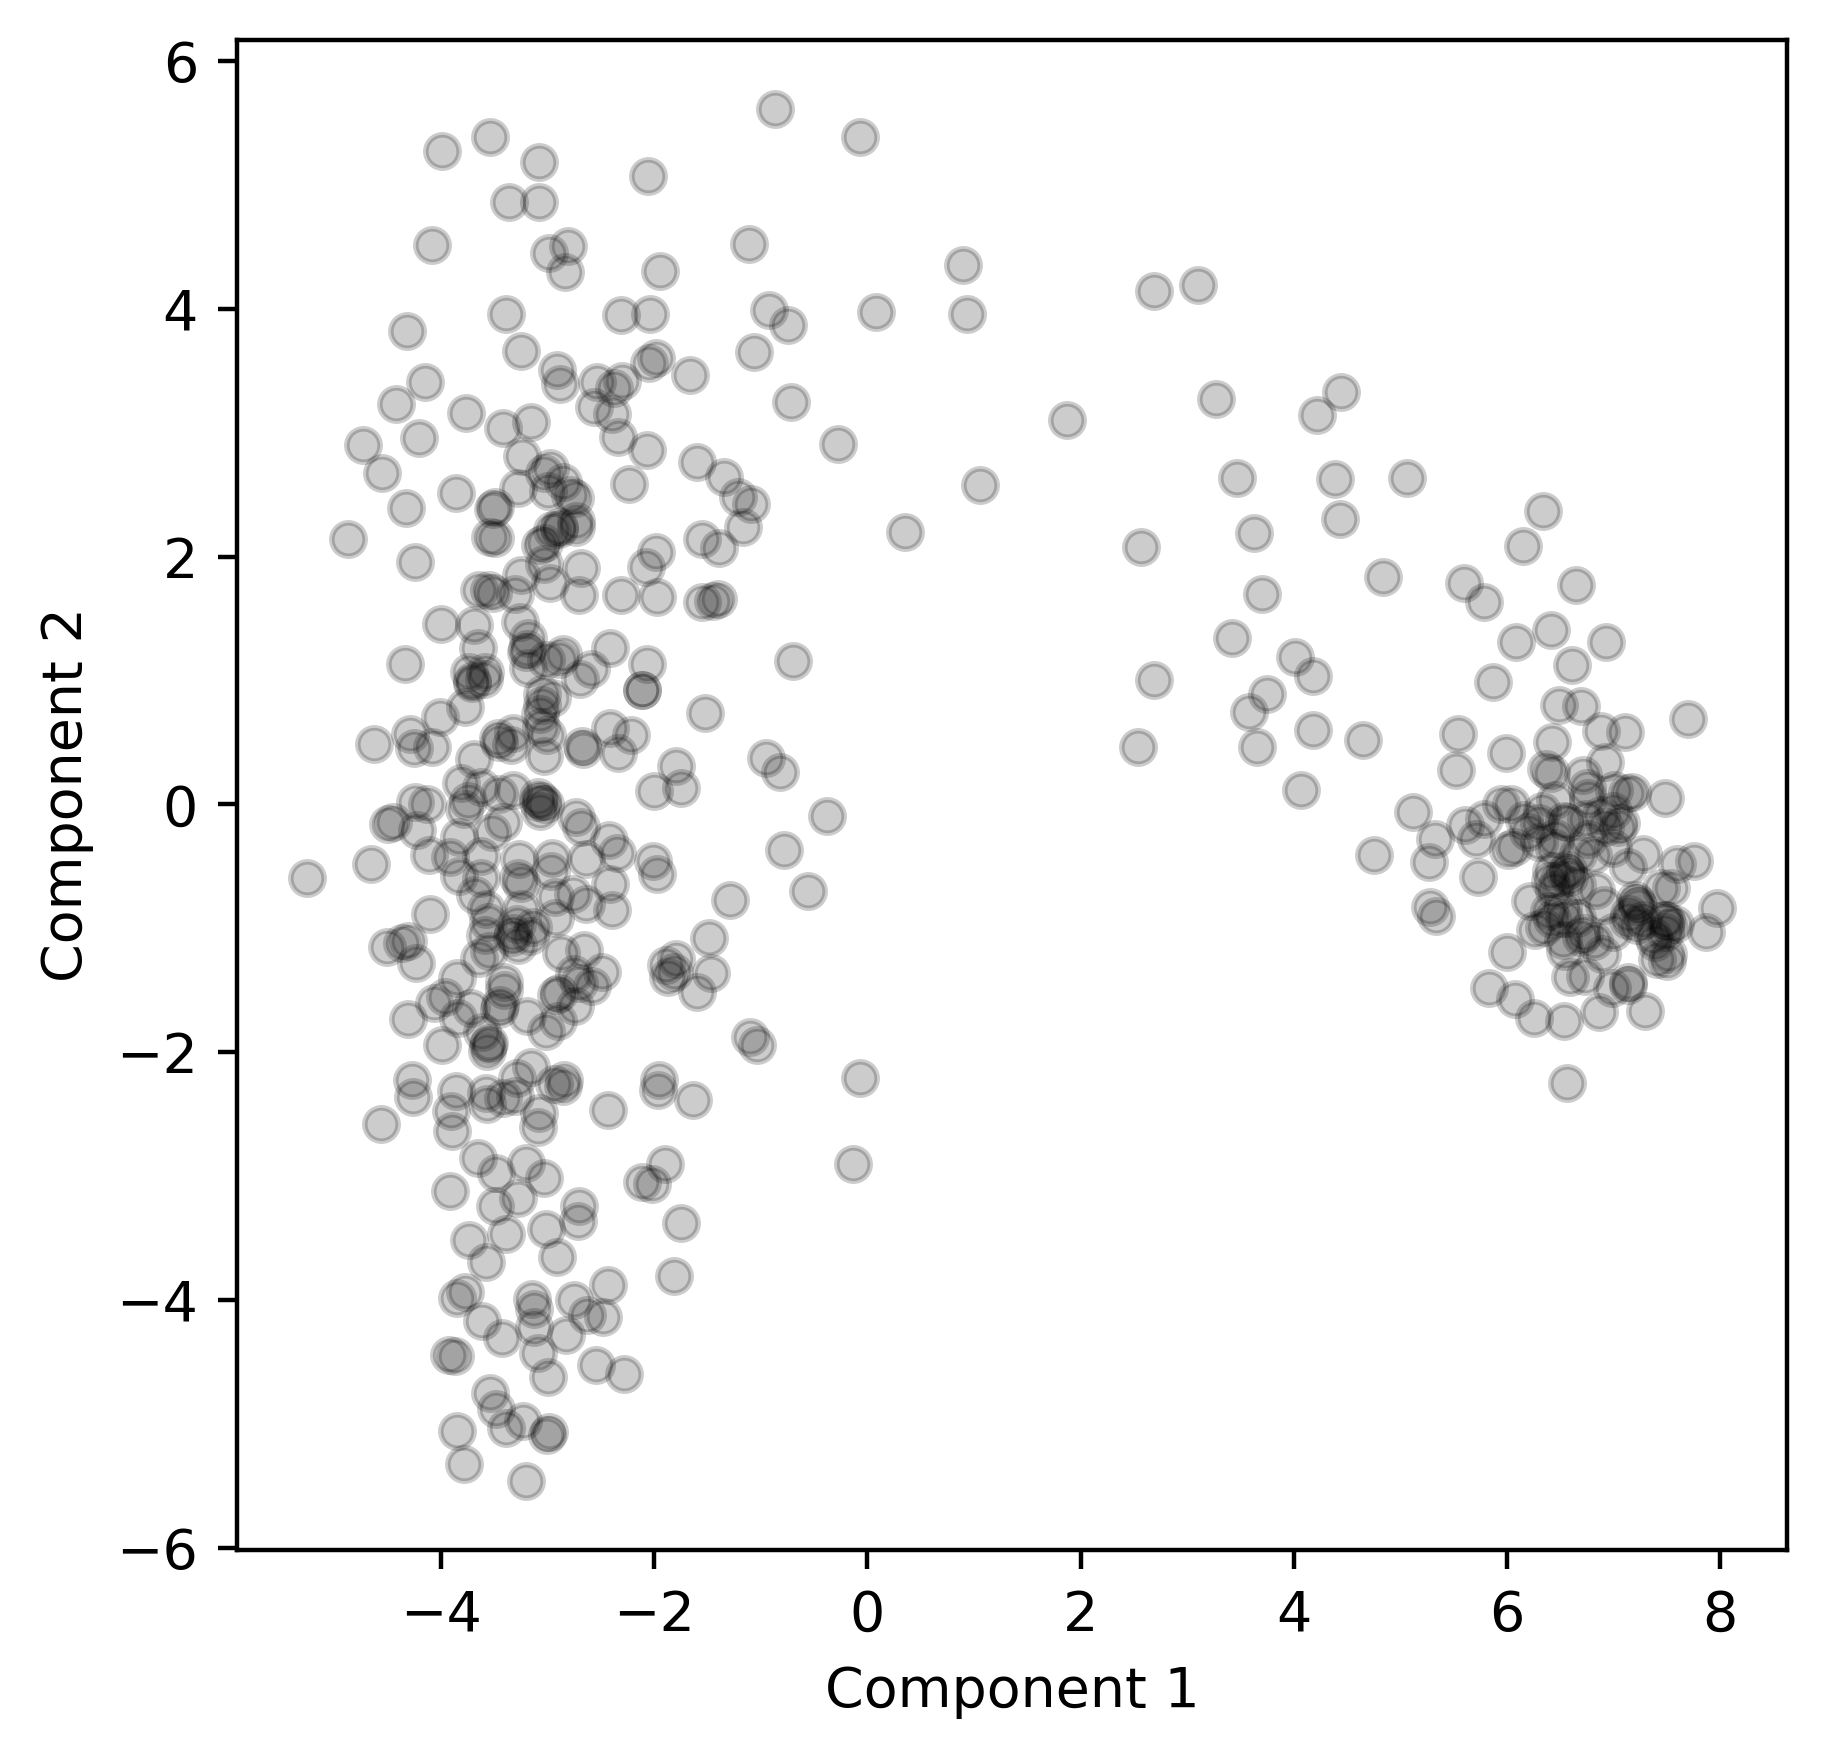

In [ ]:
plt.figure(figsize=(5, 5), dpi=400)
plt.scatter(transformed[:,0], transformed[:,1], color='black', alpha=0.2)
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

In [ ]:
from matplotlib import offsetbox

img_size = (100, 100)

filenames = list(embeddings.keys())
shown_images = np.array([[1.0, 1.0]])

fig, ax = plt.subplots(figsize=(10, 10), dpi=500)
plt.scatter(transformed[:,0], transformed[:,1], color='black', alpha=0.2)
for i in tqdm(range(transformed.shape[0])):
    dist = np.sum((transformed[i] - shown_images) ** 2, 1)
    if np.min(dist) < 4e-3: continue
    shown_images = np.concatenate([shown_images, [transformed[i]]], axis=0)
    img = cv2.resize(plt.imread(filenames[i]), (500, 500))
    imagebox = offsetbox.AnnotationBbox(
        offsetbox.OffsetImage(img, zoom=0.1), transformed[i], frameon=True, pad=0
    )
    imagebox.set(zorder=1)
    ax.add_artist(imagebox)
  
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()